## Data/Notebook Prep [ACTION REQUIRED]

In [ ]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import numpy as np

# mount drive
from google.colab import drive
import os
drive.mount("/content/drive")
from google.colab import auth 
auth.authenticate_user()


# [ACTION REQUIRED] - update below to your local filepath
os.chdir("/content/drive/My Drive/data_challenge")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read in data
t1_user_active_min = pd.read_csv('t1_user_active_min.csv')
t2_user_variant = pd.read_csv('t2_user_variant.csv')
t3_user_active_min_pre = pd.read_csv('t3_user_active_min_pre.csv')
t4_user_attributes = pd.read_csv('t4_user_attributes.csv')

## Problem Set

### Intro

Suppose you are a Data Scientist on the Mobile team at Company X. The team has just introduced a new UI design to the Company X app. The goal of the new design is to increase user engagement (measured by minutes spent on site). The team ran an A/B test to evaluate the change. Using the data, help the team understand the impact of the UI change better.

Tables provided are as follows:
    1. t1_user_active_min.csv
    2. t2_user_variant.csv
    3. t3_user_active_min_pre.csv
    4. t4_user_attributes.csv

You can download them from [redacted].

### (1) Choose your unit of analysis

In order to measure the experiment effect on user engagement, let's say you want to perform a t-test of the difference in minutes spent on site, what would be your unit of analysis (i.e. when conducting a t-test, we calculate means and variances of two samples. What does each data point represent in the samples?)? *

- [x] Total minutes per user in each group (number of data points in each group = number of users in that group)

- [ ] Total minutes per user per day in each group (number of data points in each group = number of users in that group x number of days of the experiment)

- [ ] Total minutes per group per day (number of data points in each group = number of days of the experiment)


Why do you think the other choices are not correct? Hint: think of the key assumptions of running a t-test. *

```
A key assumption of t-tests is random sampling. Assuming that randomization is at the user level, the unit of analysis should also be at the same level. Options 2 and 3 violate that assumption.
Option 2 is at a user-per-day level - meaning if a user is part of a variant, every datapoint within the timeframe associated with that user is deterministically part of the sample. True randomization should be randomly sampling users every day of the experiment.
Option 3 is at the group-per-day level. We can reasonably guess that total minutes per group per day is correlated with group size, which is not randomly determined. 
```



### (2) Conduct a t test

Use only tables 1 (t1_user_active_min.csv) and 2 (t2_user_variant.csv) for this question. 

We suspect that there might be inaccuracies in the minutes spent on site data in some rows. Think about the definition of the metric and check if there are any outliers in the data. In this context, outliers mean numbers that are obviously different due to logging errors. If so, remove them; if not, use all the data. 

Using t-test under your assumption about variance, find an appropriate 95% confidence interval of the overall average treatment effect (using the unit of analysis you identified in the previous section).

Enter the confidence interval below. Please round your answer to second place after the decimal.


```
There are a couple ways to interpret "time on site":
1. total active minutes (per day, per week, etc.)
2. session frequency (active days per week)

For t1 and t2, the only covariate we have is account age. We can check along other covariates using other tables:
1. gender
2. user_type
```


#### Outlier Exploration

In [ ]:
# variants look imbalanced:
t2_user_variant['variant_number'].value_counts()

0    40000
1    10000
Name: variant_number, dtype: int64

count    1.066402e+06
mean     3.616809e+01
std      1.270484e+03
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.700000e+01
max      9.999900e+04
Name: active_mins, dtype: float64


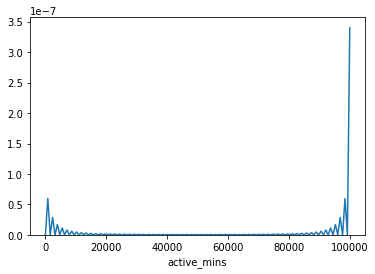

In [ ]:
print(t1_user_active_min['active_mins'].describe())
sns.distplot(t1_user_active_min['active_mins'], hist=False)

It looks like there are some outliers. Since this is time on site per user per day, the maximum value should be 24 hrs/day * 60 mins/hr = 1440.

Let's look at the distribution without outliers - it looks exponential.

Outliers removed:  172


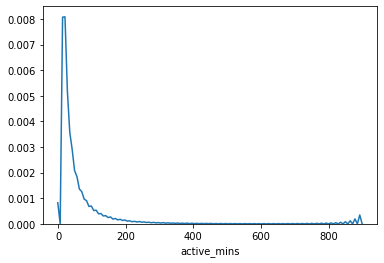

In [ ]:
t1_clean = t1_user_active_min[t1_user_active_min['active_mins'] <= 1440]
print("Outliers removed: ", len(t1_user_active_min) - len(t1_clean))

sns.distplot(t1_clean['active_mins'], hist=False)

#### Confidence Interval Calculation

Null hypothesis: there is no significant difference in the mean total active minutes per user between the treatment and control groups.

In [ ]:
def t_test_95(df1, df2, col1, col2, ci=True):
  """
  Calculates two-sided t-test for 95% CI. 
  df1, df2: pandas dataframes
  col1, col2: str column names
  ci=True: return confidence interval
  ===
  rtype: tuple (t, (ci_lower, ci_upper))
  """
  # means
  mean1, mean2 = df1[col1].mean(), df2[col2].mean()
  # standard errors
  se1, se2 = ss.sem(df1[col1]), ss.sem(df2[col2])
  # t-test
  t = (mean1 - mean2) / (se1**2.0 + se2**2.0)**0.5
  # pooled SE
  n1, n2 = len(df1), len(df2)
  sep = (((n1-1)*se1**2.0 + (n2-1)*se2**2.0) / (n1+n2-2))**0.5 # cohen's formula
  
  # sample size is >=30 for both variants, so we can use the sample SE to estimate population SE
  # also use z=1.96 for 95% CI
  return (t, (t - 1.96*sep, t + 1.96*sep))

In [ ]:
# aggregate to unit of analysis - total time per user
t1_agg = t1_clean.groupby('uid').agg('sum').reset_index()
post_df = pd.merge(t1_agg, t2_user_variant, how = 'inner', on='uid')

# separate by variants
post_treat_df = post_df[post_df['variant_number'] == 1]
post_control_df = post_df[post_df['variant_number'] == 0]

t, (ci_lower, ci_upper) = t_test_95(post_treat_df, post_control_df, 'active_mins', 'active_mins')
print("t: ", round(t, 3))
print("lower bound: ", round(ci_lower, 3))
print("upper bound: ", round(ci_upper,3))

t:  0.009
lower bound:  -21.389
upper bound:  21.407


Since the confidence interval includes 0, we fail to reject the null hypothesis.

--

Based on your findings, what is your recommended course of action regarding the new UI design? You can justify your choice in the next box. *

- [ ] Push to production
- [ ] Do not push to production
- [x] Conduct more research
- [ ] Other: _______

```
Based on the confidence interval, I fail to reject the null hypothesis. This is different than accepting the null hypothesis - just because I failed to detect an effect does not necessarily mean there doesn't exist an effect.
I think the t-test is a little simplistic in that it doesn't take into account the other covariates that are available. I'd like to explore if
* there are differences in treatment and control. While I don't know the details of the randomization process, I can tell that the classes are imbalanced (20/80). It might be worth exploring if there are covariate imbalances.
* there are differences in subgroups (while handling multiple comparisons). I can explore new users vs. mature users, gender, and user type. It may make sense from a product perspective to push this feature for a certain subset of users
* there is a time-dependent effect at play. From experience, new features may cause interesting behavior when first rolled out but peter out as users get used to the change (e.g., unusually high click through rates for new ad placements).
* the distribution after removing outliers looks exponential - I'd want to test for normality as well since that's a key assumption for t-tests.
```

### (3) Gathering additional data

You decide to dive deeper into the data, so you gather a table of active minutes by user from before the experiment began. You should now use table 3 (t3_user_active_min_pre.csv) along with tables 1 and 2 for this question.

Using the statistical method of your choice and the pre-experiment data, update your 95% confidence interval of the overall average treatment effect.

Please enter your confidence interval below, after rounding your answer to second place after the decimal.

#### Outlier Exploration

count    1.190093e+06
mean     3.220315e+01
std      1.181531e+03
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      1.400000e+01
max      9.999900e+04
Name: active_mins, dtype: float64


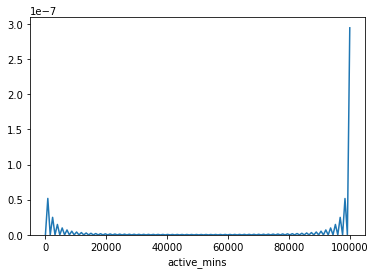

In [ ]:
# looks like there are similar logging errors:
print(t3_user_active_min_pre['active_mins'].describe())
sns.distplot(t3_user_active_min_pre['active_mins'], hist=False)

There's a similar distribution after removing outliers:

Outliers removed:  166


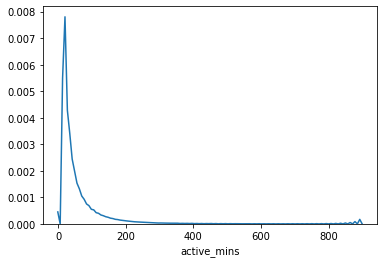

In [ ]:
t3_clean = t3_user_active_min_pre[t3_user_active_min_pre['active_mins'] <= 1440]
print("Outliers removed: ", len(t3_user_active_min_pre) - len(t3_clean))
sns.distplot(t3_clean['active_mins'], hist=False)

#### Difference-in-difference Estimator

Key assumptions:
* consistency
* parallel trends
* positivity

In [ ]:
# aggregate to unit of analysis - total time per user
t3_agg = t3_clean.groupby('uid').agg('sum').reset_index()

pre_df = pd.merge(t3_agg, t2_user_variant, how = 'inner', on='uid')
pre_df = pre_df[['uid', 'active_mins', 'variant_number']]
post_df = post_df[['uid', 'active_mins']]
active_mins_df = pd.merge(left=pre_df, right=post_df, how='inner', on='uid',
                          suffixes=('_pre','_post'))

How does the pre-experiment data change your conclusion about the treatment effect of the experiment? *
```
I found a statistically significant (t=17.99) average treatment effect of the treated (ATT) using the pre-experiment data. I used difference in differences to estimate the ATT because 
* I suspected that there might be a time-dependent effect at play.
* data is in panel form (repeated observations for same units)
```

### (4) Deeper Dive

In real life, experiment results can be nuanced. We provide you now additionally table 4 (t4_user_attributes.csv), which might help you analyze the results better. You should think about the context of the experiment and hypothesize why the analysis above could be insufficient. Explore the data and share with us your insights!

1. Given the new tables, were there any issues in treatment assignment? Was the treatment effect different for different covariates? 

2. Based on the new findings, what is your conclusion and what product recommendations would you make to the team?

Summarize your findings in a brief write-up with up to 200 words, and include one or two plots that best represent your results. Submit a single PDF file, please.

#### Covariate Analysis

In [ ]:
# create indicator columns for covariate balance tests
t4_user_attributes['gender_male'] = np.where(t4_user_attributes['gender'] == 'male', 1, 0)
t4_user_attributes['gender_female'] = np.where(t4_user_attributes['gender'] == 'female', 1, 0)
t4_user_attributes['gender_unknown'] = np.where(t4_user_attributes['gender'] == 'unknown', 1, 0)

t4_user_attributes['non_reader'] = np.where(t4_user_attributes['user_type'] == 'non_reader', 1, 0)
t4_user_attributes['reader'] = np.where(t4_user_attributes['user_type'] == 'reader', 1, 0)
t4_user_attributes['new_user'] = np.where(t4_user_attributes['user_type'] == 'new_user', 1, 0)
t4_user_attributes['contributor'] = np.where(t4_user_attributes['user_type'] == 'contributor', 1, 0)

# create and export final df
final_df = pd.merge(left=active_mins_df, right=t4_user_attributes, how='inner', on='uid')
final_df.head()

# export --> R for covariate analysis
final_df.to_csv('all_covariates.csv')

Text(0.5, 0.98, 'Total Active Minutes Per User Pre and Post Expt')

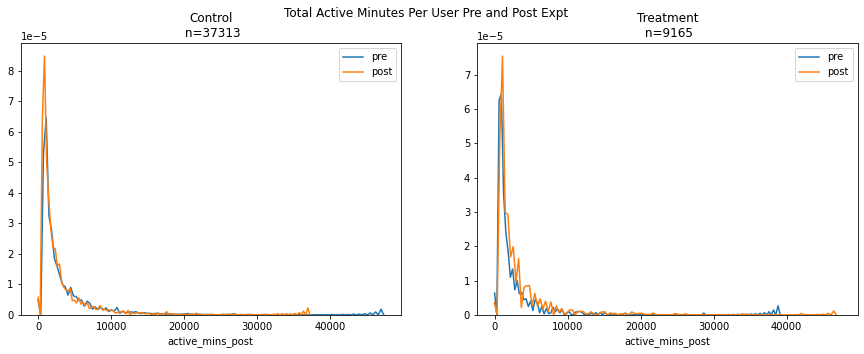

In [ ]:
# basic treatment-control analysis
fig, axs = plt.subplots(1,2, figsize=(15,5), sharex=True)
axs.flatten()

for i,variant in enumerate(['Control', 'Treatment']):
  # plots
  plot_df = final_df[final_df['variant_number'] == i]
  sns.distplot(plot_df['active_mins_pre'], hist=False, label='pre', ax=axs[i])
  sns.distplot(plot_df['active_mins_post'], hist=False, label='post', ax=axs[i])
  # title and diffs
  n = len(plot_df)
  axs[i].set_title(variant + '\n n=' + str(n))

plt.suptitle('Total Active Minutes Per User Pre and Post Expt')

Text(0.5, 0.98, 'Total Active Minutes Per User Pre and Post Expt')

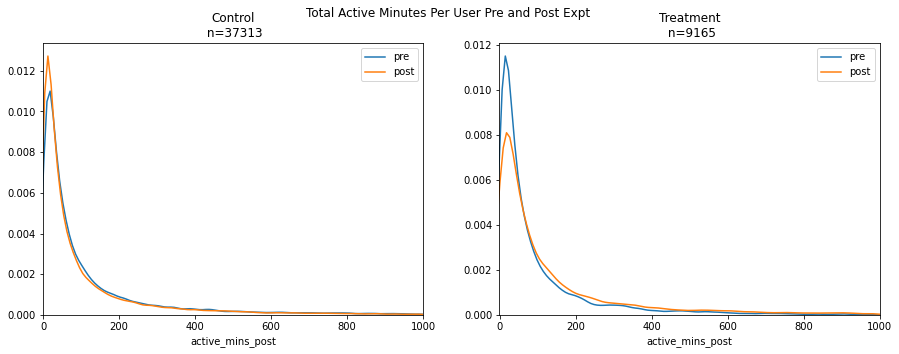

In [ ]:
# basic treatment-control analysis
fig, axs = plt.subplots(1,2, figsize=(15,5), sharex=True)
axs.flatten()

for i,variant in enumerate(['Control', 'Treatment']):
  # plots
  plot_df = final_df[final_df['variant_number'] == i]
  n = len(plot_df)
  plot_df = final_df[(final_df['variant_number'] == i) &
                     (final_df['active_mins_pre'] <= 1000) &
                     (final_df['active_mins_post'] <= 1000)]
  sns.distplot(plot_df['active_mins_pre'], hist=False, label='pre', ax=axs[i])
  sns.distplot(plot_df['active_mins_post'], hist=False, label='post', ax=axs[i])
  # title and diffs
  prepost_diff = round(plot_df['active_mins_post'].mean() - plot_df['active_mins_pre'].mean(),3)
  axs[i].set_title(variant + '\n n=' + str(n))
  axs[i].set_xlim(-1,1000)

plt.suptitle('Total Active Minutes Per User Pre and Post Expt')

Text(0.5, 0, 'Time Period')

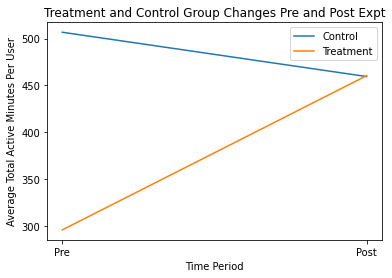

In [ ]:
agg_df = final_df[['variant_number','active_mins_pre','active_mins_post']].groupby(['variant_number']).mean().T
agg_df.columns = ['Control', 'Treatment']
agg_df.plot()
plt.title("Treatment and Control Group Changes Pre and Post Expt")
plt.xticks(ticks=[0,1], labels=['Pre','Post'])
plt.ylabel('Average Total Active Minutes Per User')
plt.xlabel('Time Period')

Text(0.04, 0.5, 'User Type')

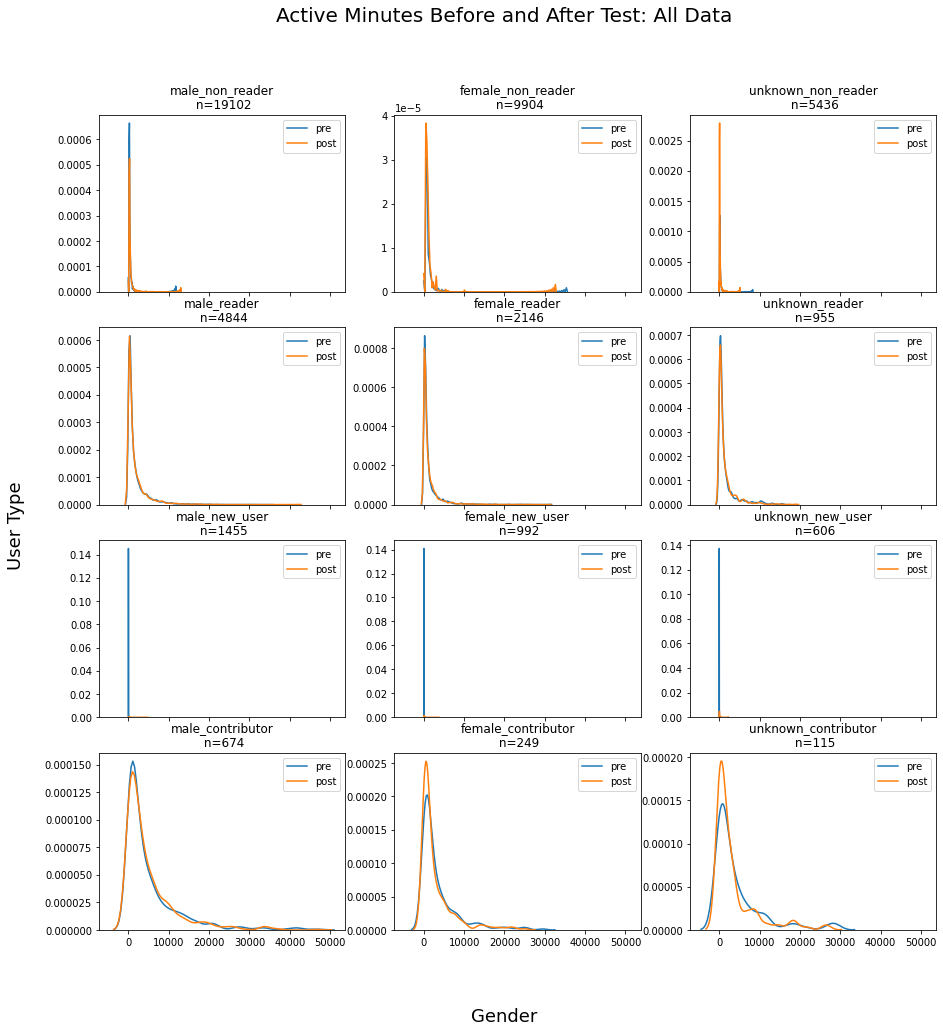

In [ ]:
# cross-sectional analysis
fig, axs = plt.subplots(4,3, figsize=(15,15), sharex=True)
axs.flatten()

for i,user_type in enumerate(final_df['user_type'].unique()):
  for j,gender in enumerate(final_df['gender'].unique()):
    # grab data
    plot_df = final_df[(final_df['user_type'] == user_type) & (final_df['gender'] == gender)]
    
    # labels
    group_name = gender + "_" + user_type
    n = len(plot_df)
    sns.distplot(plot_df['active_mins_pre'], hist=False, label='pre', ax=axs[i,j])
    sns.distplot(plot_df['active_mins_post'], hist=False, label='post', ax=axs[i,j])
    plt.title(group_name)
    axs[i,j].xaxis.label.set_visible(False)
    axs[i,j].set_title(group_name + '\n n=' + str(n))

plt.suptitle('Active Minutes Before and After Test: All Data', fontsize=20)
fig.text(0.5, 0.04, 'Gender', ha='center', fontsize=18)
fig.text(0.04, 0.5, 'User Type', va='center', rotation='vertical', fontsize=18)

Text(0.06, 0.5, 'User Type')

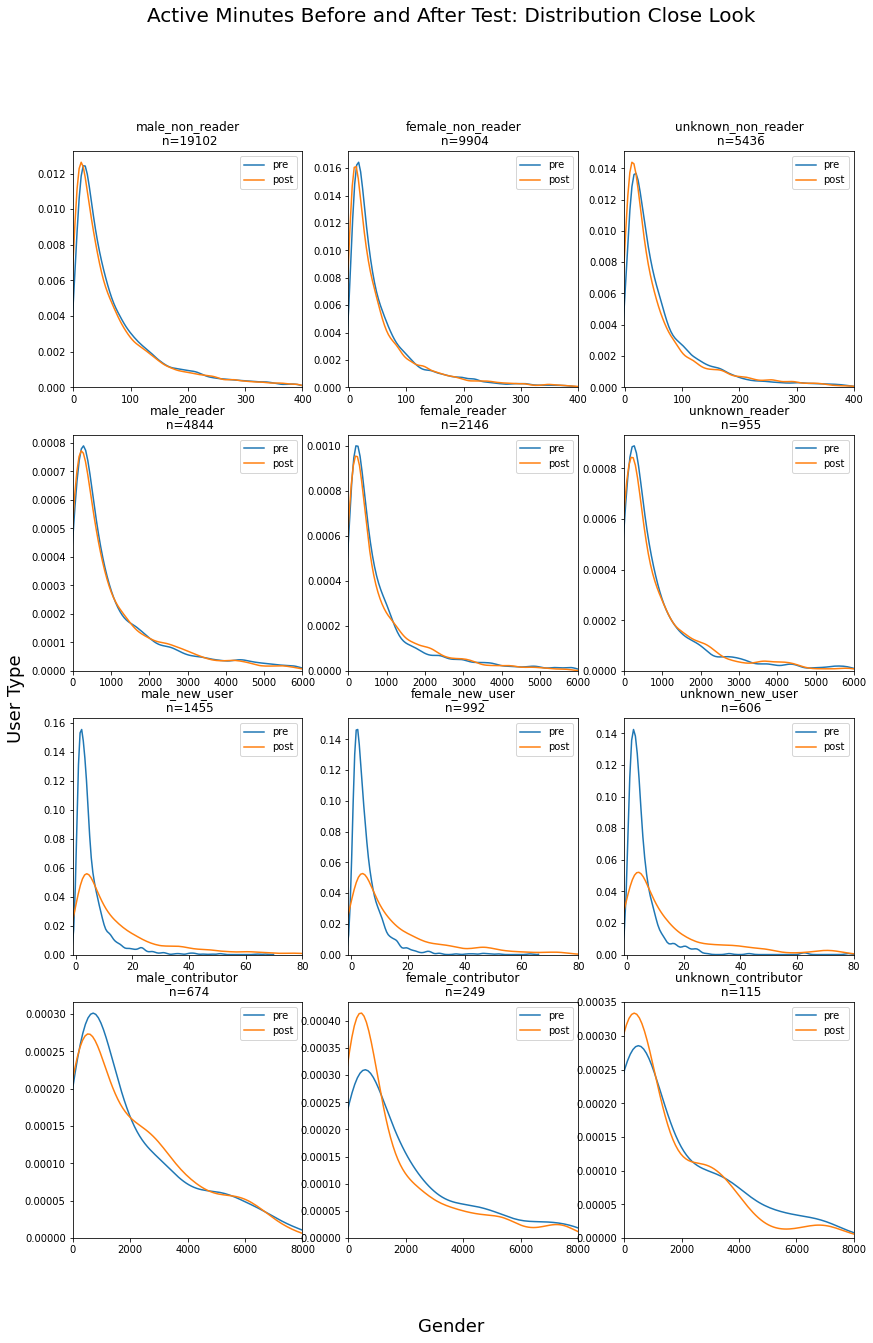

In [ ]:
# cross-sectional analysis: close look
fig, axs = plt.subplots(4,3, figsize=(14,20))
axs.flatten()

for i,user_type in enumerate(final_df['user_type'].unique()):
  for j,gender in enumerate(final_df['gender'].unique()):
    # grab data
    plot_df = final_df[(final_df['user_type'] == user_type) & (final_df['gender'] == gender)]
    n = len(plot_df)
    # labels
    group_name = gender + "_" + user_type
    if user_type == 'non_reader':
      threshold = 400
    elif user_type == 'reader':
      threshold = 6000
    elif user_type == 'new_user':
      threshold = 80
    elif user_type == 'contributor':
      threshold = 8000
    # grab data
    plot_df = final_df[(final_df['user_type'] == user_type) & 
                       (final_df['gender'] == gender) & 
                       (final_df['active_mins_post'] <= threshold) & 
                       (final_df['active_mins_pre'] <= threshold)]

    sns.distplot(plot_df['active_mins_pre'], hist=False, label='pre', ax=axs[i,j])
    sns.distplot(plot_df['active_mins_post'], hist=False, label='post', ax=axs[i,j])
    plt.title(group_name)
    plt.xlabel('active_mins')
    axs[i,j].xaxis.label.set_visible(False)
    axs[i,j].set_xlim(-1,threshold)
    axs[i,j].set_title(group_name + '\n n=' + str(n))

plt.suptitle('Active Minutes Before and After Test: Distribution Close Look', fontsize=20)
fig.text(0.5, 0.06, 'Gender', ha='center', fontsize=18)
fig.text(0.06, 0.5, 'User Type', va='center', rotation='vertical', fontsize=18)


See R file for estimated treatment effects by subgroup.

### (5) Going Beyond

Aside from this new UI design, our mobile team is looking into improving retention of app users. In other words, we hope that users who have started using the app come back often to continue using our app. Assuming you have access to all our data, what data analyses would you do to shape product strategies in this area?

List 3 ideas, please 
a) be as specific as possible - clearly define the metrics you want to look at, such that following your prescription, a data scientist on the team can produce the same numbers; 
b) explain how you will generate insights from the data. As an example of a specific analysis idea (for a different analysis purpose): "I will look at the total number of answers written in the last month, breaking down by country. If the data shows X, this means Y and I would recommend Z as our strategy."


```
1. Activation Rates: I will look at the retention rates of app users by activation level (e.g. sign up, added credential, answered a question, followed a space, etc.). If the data shows a large drop off at any activation level, this likely means it is a bottleneck, and I would recommend strategies to increase retention at that activation level, such as UI changes/tool tips or push notifications. 

2. User types: I will look at the proportion of user types, broken down by app (e.g. Android, iOS) and compared to other platforms (e.g. native web, mobile web). If the user type proportions differ greatly on Android and/or iOS compared to other platforms, this likely means that app users engage differently than users on other platforms. For example, if app users are more likely to be readers and less likely to be contributors, I would recommend strategies to encourage readers to contribute, such as making answer/question-posting more streamlined.

3. Deep linking: I will look at mobile web users - specifically those who browse a session without redirecting to the app or to download the app. If the data shows a significant number of users with this behavior, there is an opportunity to increase app user retention through strategies such as (1) forcing users to redirect to the app after, say, 3 screenviews and (2) offering a more streamlined app experience to encourage app downloads.

```